# Détection d'objets et comparaison d'images avec HOG

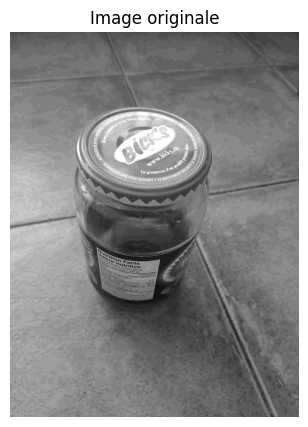

In [112]:

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Charger l'image en niveaux de gris
image_query_name = "./TP1_data/pickles_query.jpg"
image = cv2.imread(image_query_name, cv2.IMREAD_GRAYSCALE)

# Afficher l'image originale
plt.figure(figsize=(10, 5))
plt.imshow(image, cmap="gray")
plt.title("Image originale")
plt.axis("off")
plt.show()


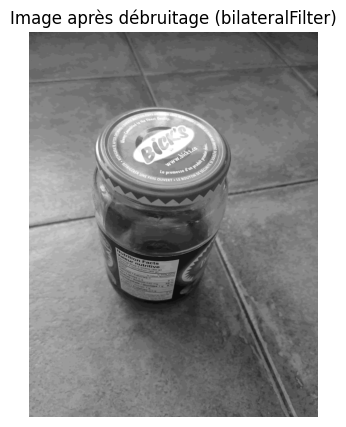

In [113]:

# 1. Appliquer un filtre de débruitage adaptatif (bilateralFilter)
blurred_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

# Afficher l'image floutée
plt.figure(figsize=(10, 5))
plt.imshow(blurred_image, cmap="gray")
plt.title("Image après débruitage (bilateralFilter)")
plt.axis("off")
plt.show()


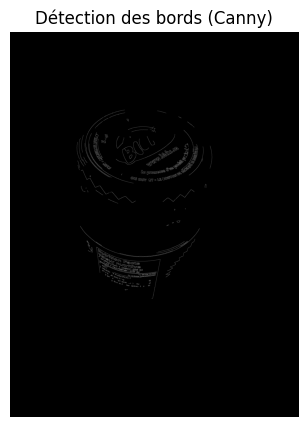

In [114]:

# 2. Détection des bords avec Canny (ajustement des seuils)
edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
edges_dilated = cv2.dilate(edges, kernel, iterations=1)

# Afficher les bords détectés par Canny
plt.figure(figsize=(10, 5))
plt.imshow(edges, cmap="gray")
plt.title("Détection des bords (Canny)")
plt.axis("off")
plt.show()


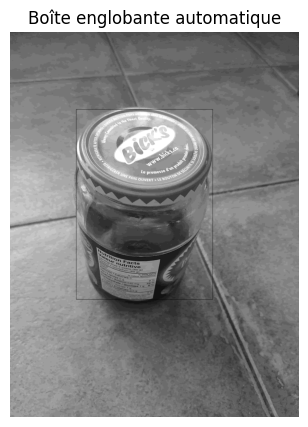

In [115]:

# 4. Trouver les contours
contours, _ = cv2.findContours(edges_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 5. Filtrer les contours pour ignorer les petits objets
filtered_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 1000:  # Ajustez ce seuil selon votre image
        filtered_contours.append(contour)

# 6. Trouver une seule boîte englobante autour des contours filtrés
if filtered_contours:
    all_points = np.vstack(filtered_contours)
    x, y, w, h = cv2.boundingRect(all_points)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 0), 2)  # Dessiner la boîte englobante

# Afficher l'image avec la boîte englobante
plt.figure(figsize=(10, 5))
plt.imshow(image, cmap="gray")
plt.title("Boîte englobante automatique")
plt.axis("off")
plt.show()


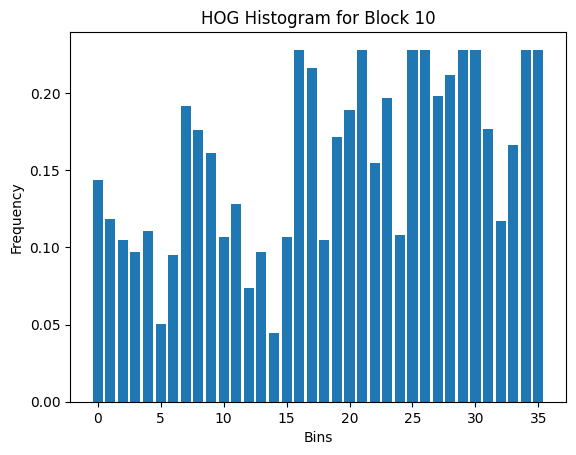

In [116]:

# 7. Calcul des caractéristiques HOG
win_size = (64, 64)  # Taille de la fenêtre (patch d'image)
block_size = (16, 16)  # Taille de chaque bloc
block_stride = (8, 8)  # Pas pour déplacer le bloc
cell_size = (8, 8)  # Taille de chaque cellule dans un bloc
nbins = 9  # Nombre de bins de l'histogramme

# Créer l'objet HOGDescriptor
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)

# Redimensionner l'image pour correspondre à la taille de la fenêtre HOG
image_resized = cv2.resize(image, win_size)



# Calculer les caractéristiques HOG pour l'image entière
hog_features = hog.compute(image_resized)

# Afficher les caractéristiques HOG pour un bloc spécifique
n_blocks_x = (win_size[0] - block_size[0]) // block_stride[0] + 1
n_blocks_y = (win_size[1] - block_size[1]) // block_stride[1] + 1
n_blocks = n_blocks_x * n_blocks_y
hog_features_per_block = np.reshape(hog_features, (n_blocks, -1))

# Afficher l'histogramme HOG pour un bloc spécifique
block_index = 10  # Choisir le bloc à visualiser
plt.bar(range(hog_features_per_block.shape[1]), hog_features_per_block[block_index])
plt.title(f'HOG Histogram for Block {block_index}')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.show()


In [117]:
# Fonction pour calculer la distance entre deux images basée sur HOG
def compute_dist(image_name1, image_name2, with_ROI=False):
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    
    # Charger les images
    image1 = cv2.imread(image_name1, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image_name2, cv2.IMREAD_GRAYSCALE)
    
    # Vérifier si les images ont été chargées correctement
    if image1 is None:
        print(f"Erreur : Impossible de charger l'image {image_name1}")
        return None
    if image2 is None:
        print(f"Erreur : Impossible de charger l'image {image_name2}")
        return None
    
    # Redimensionner les images pour correspondre à la taille de la fenêtre HOG
    
    # if with_ROI:
    #     image_resized1 = extract_roi(image1)
    #     image_resized2 = extract_roi(image2)
    # else : 
    image_resized1 = cv2.resize(image1, win_size)
    image_resized2 = cv2.resize(image2, win_size)
    # Calculer les caractéristiques HOG
    hog_features1 = hog.compute(image_resized1)
    hog_features2 = hog.compute(image_resized2)
    
    # Calculer la distance entre les deux descripteurs HOG
    dist = np.linalg.norm(hog_features1 - hog_features2)
    return dist

# Fonction pour calculer la distance entre une image de requête et toutes les images d'une base de données
def compute_dist_all(image_query_name, with_ROI=False):
    list_dist = []
    if with_ROI : 
        database_path = "./TP1_data/database_with_cropped_images"
    else : 
        database_path = "./TP1_data/database"  # Remplacez par le chemin correct de votre base de données
    
    # Vérifier si le dossier existe
    if not os.path.exists(database_path):
        print(f"Erreur : Le dossier {database_path} n'existe pas.")
        return list_dist
    
    # Parcourir tous les fichiers dans le dossier
    for file_name in os.listdir(database_path):
        if file_name.endswith(".jpg"):
            image_path = os.path.join(database_path, file_name)
            
            # Calculer la distance
            dist = compute_dist(image_query_name, image_path, with_ROI)
            
            # Ajouter à la liste si la distance a été calculée avec succès
            if dist is not None:
                list_dist.append((file_name, dist))
    
    return list_dist

#Fonction pour extraire la région d'intérêt (ROI) de l'image en se basant sur la boîte englobante tracée plus tôt 

def extract_roi(image):
    blurred_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)  #on floute l'image
    edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)   # on trouve les bords
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))  # on crée un noyau pour la dilatation
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)  # on dilate les bords
    # 4. Trouver les contours
    contours, _ = cv2.findContours(edges_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 5. Filtrer les contours pour ignorer les petits objets
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000:  # Ajustez ce seuil selon votre image
            filtered_contours.append(contour)

    # 6. Trouver une seule boîte englobante autour des contours filtrés
    if filtered_contours:
        all_points = np.vstack(filtered_contours)
        x, y, w, h = cv2.boundingRect(all_points)  # boîte englobante
        
    roi = image[y:y+h, x:x+w] # on extrait la région d'intérêt
    roi_resized = cv2.resize(roi, win_size)  # on redimensionne l'image
    return roi_resized
        

# Calculer les distances pour toutes les images de la base de données
list_dist = compute_dist_all(image_query_name)

# Afficher les 5 images les plus proches
if list_dist:
    short_list = sorted(list_dist, key=lambda x: x[1])[:5]
    print("Les 5 images les plus proches :", short_list)
else:
    print("Aucune image trouvée ou aucune distance calculée.")

Les 5 images les plus proches : [('pickles_1.jpg', 3.2704923), ('pickles_2.jpg', 3.4949603), ('cat_4.jpg', 3.6455195), ('dolphin_1.jpg', 3.6801233), ('pickles_4.jpg', 3.7075348)]


In [118]:
list_dist_with_ROI = compute_dist_all(image_query_name, with_ROI=True)
if list_dist_with_ROI:
    short_list_with_ROI = sorted(list_dist_with_ROI, key=lambda x: x[1])[:5]
    print("Les 5 images les plus proches avec ROI:", short_list_with_ROI)
else:
    print("Aucune image trouvée ou aucune distance calculée avec ROI.")

Les 5 images les plus proches avec ROI: [('pickles_1.jpg', 3.2704923), ('pickles_2.jpg', 3.4949603), ('cat_4.jpg', 3.6455195), ('dolphin_1.jpg', 3.6801233), ('pickles_4.jpg', 3.7075348)]


In [123]:
list_of_items = ["airplane","ball","car_cropped","cat","dolphin","face","lotus_cropped","pickles","strawberry"  ]
list_count_valid_With_ROI = []
for item in list_of_items :
    # Charger l'image en niveaux de gris
    image_query_name = "./TP1_data/"+item+"_query.jpg"
    count = 0
    list_dist = compute_dist_all(image_query_name, with_ROI=True)
    if list_dist:
        short_list = sorted(list_dist, key=lambda x: x[1])[:5]
        for item_tuple in short_list:
            if item  in item_tuple[0]:
                count +=1
        list_count_valid_With_ROI.append((item,count))
        print("Les 5 images les plus proches avec ROI pour "+item+" :", short_list)
    else:
        print("Aucune image trouvée ou aucune distance calculée avec ROI pour "+item+".")
    

Les 5 images les plus proches avec ROI pour airplane : [('airplane_1.jpg', 3.7721262), ('airplane_3.jpg', 3.8803005), ('airplane_2.jpg', 4.0715833), ('airplane_5.jpg', 4.209872), ('cat_4.jpg', 4.2458105)]
Les 5 images les plus proches avec ROI pour ball : [('cat_4.jpg', 4.6807046), ('ball4_cropped.jpg', 4.728396), ('lotus_4.jpg', 4.813157), ('face_5.jpg', 4.8365216), ('cat_2.jpg', 4.8373837)]
Les 5 images les plus proches avec ROI pour car_cropped : [('car_cropped3.jpg', 3.1485965), ('car_cropped2.jpg', 3.4015555), ('car_cropped5.jpg', 3.645246), ('car_cropped4.jpg', 3.652178), ('car_cropped1.jpg', 3.7187338)]
Les 5 images les plus proches avec ROI pour cat : [('cat_2.jpg', 3.1536694), ('lotus_4.jpg', 3.4170084), ('cat_3.jpg', 3.430617), ('cat_5.jpg', 3.6031983), ('cat_4.jpg', 3.6498756)]
Les 5 images les plus proches avec ROI pour dolphin : [('dolphin_5.jpg', 3.979063), ('dolphin_1.jpg', 4.208593), ('pickles_5.jpg', 4.294418), ('cat_2.jpg', 4.371128), ('ball_1.jpg', 4.3966203)]
Les 5 

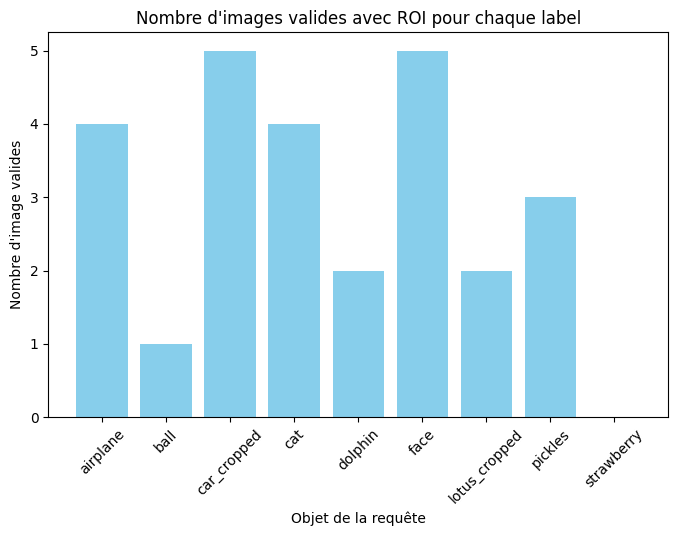

In [124]:
labels, values = zip(*list_count_valid_With_ROI)  # Convertit la liste de tuples en deux listes distinctes

# Créer le diagramme en barres
plt.figure(figsize=(8, 5))  # Taille de la figure
plt.bar(labels, values, color='skyblue')  # Couleur des barres

# Ajouter des titres et labels
plt.xlabel("Objet de la requête")
plt.ylabel("Nombre d'image valides")
plt.title("Nombre d'images valides avec ROI pour chaque label")
plt.xticks(rotation=45)  # Rotation des labels pour meilleure lisibilité

# Afficher le graphique
plt.show()

In [121]:
list_of_items = ["airplane","ball","car","cat","dolphin","face","lotus","pickles","strawberry"  ]
list_count_valid = []
for item in list_of_items :
    # Charger l'image en niveaux de gris
    image_query_name = "./TP1_data/"+item+"_query.jpg"
    count = 0
    list_dist = compute_dist_all(image_query_name, with_ROI=False)
    if list_dist:
        short_list = sorted(list_dist, key=lambda x: x[1])[:5]
        for item_tuple in short_list:
            if item  in item_tuple[0]:
                count +=1
        list_count_valid.append((item,count))
        print("Les 5 images les plus proches  pour "+item+" :", short_list)
    else:
        print("Aucune image trouvée ou aucune distance calculée  pour "+item+".")

Les 5 images les plus proches  pour airplane : [('airplane_1.jpg', 3.7721262), ('airplane_3.jpg', 3.8803005), ('airplane_2.jpg', 4.0715833), ('airplane_5.jpg', 4.209872), ('cat_4.jpg', 4.2458105)]
Les 5 images les plus proches  pour ball : [('cat_4.jpg', 4.6807046), ('lotus_4.jpg', 4.813157), ('face_5.jpg', 4.8365216), ('cat_2.jpg', 4.8373837), ('face_3.jpg', 4.8986564)]
Les 5 images les plus proches  pour car : [('car_4.jpg', 3.718222), ('dolphin_1.jpg', 3.8135018), ('car_2.jpg', 3.821106), ('lotus_4.jpg', 4.104045), ('cat_1.jpg', 4.1230135)]
Les 5 images les plus proches  pour cat : [('cat_2.jpg', 3.1536694), ('lotus_4.jpg', 3.4170084), ('cat_3.jpg', 3.430617), ('cat_5.jpg', 3.6031983), ('cat_4.jpg', 3.6498756)]
Les 5 images les plus proches  pour dolphin : [('dolphin_5.jpg', 3.979063), ('dolphin_1.jpg', 4.208593), ('pickles_5.jpg', 4.294418), ('cat_2.jpg', 4.371128), ('ball_1.jpg', 4.3966203)]
Les 5 images les plus proches  pour face : [('face_2.jpg', 3.1785924), ('face_5.jpg', 3.19

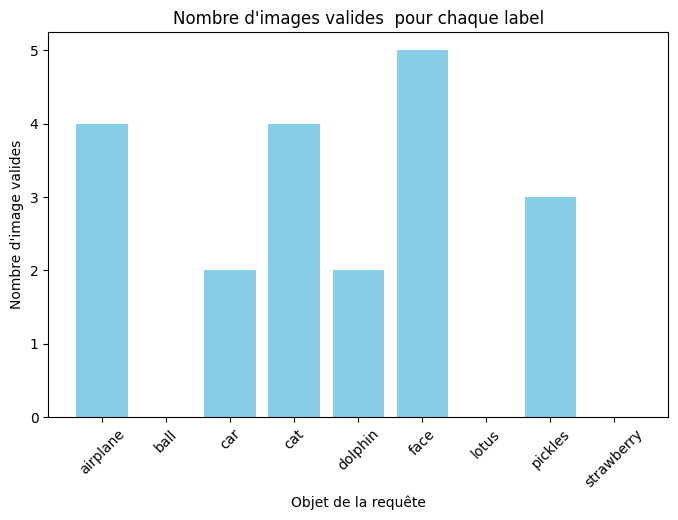

In [122]:
labels, values = zip(*list_count_valid)  # Convertit la liste de tuples en deux listes distinctes

# Créer le diagramme en barres
plt.figure(figsize=(8, 5))  # Taille de la figure
plt.bar(labels, values, color='skyblue')  # Couleur des barres

# Ajouter des titres et labels
plt.xlabel("Objet de la requête")
plt.ylabel("Nombre d'image valides")
plt.title("Nombre d'images valides  pour chaque label")
plt.xticks(rotation=45)  # Rotation des labels pour meilleure lisibilité

# Afficher le graphique
plt.show()